In [1]:
%cd ../

/home/users/dmoreno2016/VisionTransformers


/home/users/dmoreno2016/.virtualenvs/ViT/lib/python3.11/site-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [2]:
import os
import pandas as pd
import numpy as np
import json
import pickle

import torch
import matplotlib.pyplot as plt

import glob
import torch

from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

import os
os.environ["PATH"] = "/home/users/dmoreno2016/.TinyTeX/bin/x86_64-linux:" + os.environ["PATH"]

plt.rcParams.update({
    "text.usetex": True,
    "pgf.texsystem": "pdflatex",
    "font.family": "serif",
    "font.serif": ["Palatino"],
})

os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

%load_ext autoreload
%autoreload 2


def get_confusion_matrix(mean_matrix, std_matrix, order_classes):
    # Graficando la matriz media
    cmap = plt.cm.Blues
    fig, ax = plt.subplots(figsize=(13, 13)) #, dpi=110)
    im = ax.imshow(np.around(mean_matrix, decimals=2), interpolation='nearest', cmap=cmap)

    # color map
    new_color = cmap(1.0) 

    # Añadiendo manualmente las anotaciones con la media y desviación estándar
    for i in range(mean_matrix.shape[0]):
        for j in range(mean_matrix.shape[1]):
            if mean_matrix[i, j] >= 0.005:
                #print(mean_matrix[i, j])
                text = f'{np.around(mean_matrix[i, j], decimals=2)}\n±{np.around(std_matrix[i, j], decimals=2)}'
                color = "white" if mean_matrix[i, j] > 0.5 else new_color  # Blanco para la diagonal, tono de azul para otras celdas
                ax.text(j, i, text, ha="center", va="center", color=color, fontsize=12.5)
            else:
                text = f'{np.around(mean_matrix[i, j], decimals=2)}'
                color = "white" if mean_matrix[i, j] > 0.5 else new_color  # Blanco para la diagonal, tono de azul para otras celdas
                ax.text(j, i, text, ha="center", va="center", color=color, fontsize=12.5)

    # Ajustes finales y mostrar la gráfica
    ax.tick_params(axis='both', which='major', labelsize=14)
    ax.set_xticks(np.arange(len(order_classes)))
    ax.set_yticks(np.arange(len(order_classes)))
    ax.set_xticklabels(order_classes)
    ax.set_yticklabels(order_classes)
    plt.setp(ax.get_xticklabels(), rotation=90, ha="right", rotation_mode="anchor")

    ax.xaxis.label.set_size(16)
    ax.yaxis.label.set_size(16)
    ax.xaxis.labelpad = 13
    ax.yaxis.labelpad = 13

    plt.tight_layout()
    plt.show()

In [3]:
import mlflow
import logging

def get_experiment_id_mlflow(exp_name):
    experiment = mlflow.get_experiment_by_name(exp_name)
    if experiment:
        experiment_id = experiment.experiment_id
        logging.info(f"Experiment ID for '{exp_name}': {experiment_id}")
    else:
        logging.info(f"Experiment '{exp_name}' not found.")
    return experiment_id

def get_run_id_mlflow(experiment_id, run_name):
    filter_string = f"tags.mlflow.runName = '{run_name}'"
    runs = mlflow.search_runs(experiment_ids=[experiment_id], filter_string=filter_string)
    if not runs.empty:  # Check if the DataFrame is empty
        run_id = runs.iloc[0].run_id  # Get the run ID of the first row
        logging.info(f"Run ID for '{run_name}': {run_id}")
    else:
        logging.info(f"Run '{run_name}' not found in experiment '{experiment_id}'.")
    return run_id

def handle_ckpt_dir(config, fold=None):
    mlflow.set_tracking_uri(f"file:{config['checkpoint']['results_dir']}/ml-runs")
    exp_name = f"{config['checkpoint']['exp_name']}"
    exp_id = get_experiment_id_mlflow(exp_name)
    ckpt_dir = '{}/ml-runs/{}'.format(config['checkpoint']['results_dir'], exp_id)

    run_name = config['checkpoint']['run_name']
    if 'ft_classification' in exp_name:
        run_name = 'Fold_{}_{}'.format(fold, run_name)  
        run_id = get_run_id_mlflow(exp_id, run_name)
        ckpt_dir += '/{}'.format(run_id)
    else:
        run_id = get_run_id_mlflow(exp_id, run_name)
        ckpt_dir += '/{}'.format(run_id) 

    ckpt_dir += '/artifacts/model'
    return ckpt_dir

In [4]:
path_save_results = 'images'

order_classes = ['RRab', 'RRc', 'Cep_0', 'Cep_1', 'EC', 'LPV']

## Single-band MACHO

### 20 samples per class

In [5]:
# 20 SPC - overlay

dict_fold_mlflow = {
    0: '2025-01-26_08-40-31',
    1: '2025-01-26_08-40-31',
    2: '2025-01-26_08-40-31',
}

matrices = []
for fold, run_name in dict_fold_mlflow.items(): 

    config = {
        'mlflow_dir': 'ml-runs',

        'checkpoint': {
            'exp_name': 'ft_classification/macho/best_params',
            'run_name': run_name,
            'results_dir': './results/macho',
        },

        'loader': {
            'fold': fold
            }
    }

    fold = config['loader']['fold']
    ckpt_dir = handle_ckpt_dir(config, fold=fold)
    ckpt_model = sorted(glob.glob(ckpt_dir + "/*.ckpt"))[-1]

    # Folder
    experiment_id = get_experiment_id_mlflow(config['checkpoint']['exp_name'])
    run_name = f"Fold_{fold}_{config['checkpoint']['run_name']}"
    run_id = get_run_id_mlflow(experiment_id, run_name)
    EXPDIR = '{}/ml-runs/{}/{}/artifacts'.format(config['checkpoint']['results_dir'], experiment_id, run_id)

    df_predictions = pd.read_parquet(f'{EXPDIR}/predictions_test.parquet')
    y_test = df_predictions['y_true'].values
    y_pred = df_predictions['y_pred'].values
    cm = confusion_matrix(y_test, y_pred, labels=order_classes, normalize='true')
    matrices.append(cm)

# Calculando la media y la desviación estándar
mean_matrix_single_20 = np.mean(matrices, axis=0)
std_matrix_single_20 = np.std(matrices, axis=0)

### 500 samples per class

In [6]:
# 500 SPC - overlay

dict_fold_mlflow = {
    0: '2025-01-25_18-36-02',
    1: '2025-01-25_18-36-02',
    2: '2025-01-25_18-36-02',
}

matrices = []
for fold, run_name in dict_fold_mlflow.items(): 

    config = {
        'mlflow_dir': 'ml-runs',

        'checkpoint': {
            'exp_name': 'ft_classification/macho/best_params',
            'run_name': run_name,
            'results_dir': './results/macho',
        },

        'loader': {
            'fold': fold
            }
    }

    fold = config['loader']['fold']
    ckpt_dir = handle_ckpt_dir(config, fold=fold)
    ckpt_model = sorted(glob.glob(ckpt_dir + "/*.ckpt"))[-1]

    # Folder
    experiment_id = get_experiment_id_mlflow(config['checkpoint']['exp_name'])
    run_name = f"Fold_{fold}_{config['checkpoint']['run_name']}"
    run_id = get_run_id_mlflow(experiment_id, run_name)
    EXPDIR = '{}/ml-runs/{}/{}/artifacts'.format(config['checkpoint']['results_dir'], experiment_id, run_id)

    df_predictions = pd.read_parquet(f'{EXPDIR}/predictions_test.parquet')
    y_test = df_predictions['y_true'].values
    y_pred = df_predictions['y_pred'].values
    cm = confusion_matrix(y_test, y_pred, labels=order_classes, normalize='true')
    matrices.append(cm)

# Calculando la media y la desviación estándar
mean_matrix_single_500 = np.mean(matrices, axis=0)
std_matrix_single_500 = np.std(matrices, axis=0)

### Full dataset

In [7]:
# all SPC - overlay

dict_fold_mlflow = {
    0: '2025-01-25_18-31-57',
    1: '2025-01-25_18-31-57',
    2: '2025-01-25_18-31-57',
}

matrices = []
for fold, run_name in dict_fold_mlflow.items(): 

    config = {
        'mlflow_dir': 'ml-runs',

        'checkpoint': {
            'exp_name': 'ft_classification/macho/best_params',
            'run_name': run_name,
            'results_dir': './results/macho',
        },

        'loader': {
            'fold': fold
            }
    }

    fold = config['loader']['fold']
    ckpt_dir = handle_ckpt_dir(config, fold=fold)
    ckpt_model = sorted(glob.glob(ckpt_dir + "/*.ckpt"))[-1]

    # Folder
    experiment_id = get_experiment_id_mlflow(config['checkpoint']['exp_name'])
    run_name = f"Fold_{fold}_{config['checkpoint']['run_name']}"
    run_id = get_run_id_mlflow(experiment_id, run_name)
    EXPDIR = '{}/ml-runs/{}/{}/artifacts'.format(config['checkpoint']['results_dir'], experiment_id, run_id)

    df_predictions = pd.read_parquet(f'{EXPDIR}/predictions_test.parquet')
    y_test = df_predictions['y_true'].values
    y_pred = df_predictions['y_pred'].values
    cm = confusion_matrix(y_test, y_pred, labels=order_classes, normalize='true')
    matrices.append(cm)

# Calculando la media y la desviación estándar
mean_matrix_single_all = np.mean(matrices, axis=0)
std_matrix_single_all = np.std(matrices, axis=0)

### Confusion matrices (single-band)

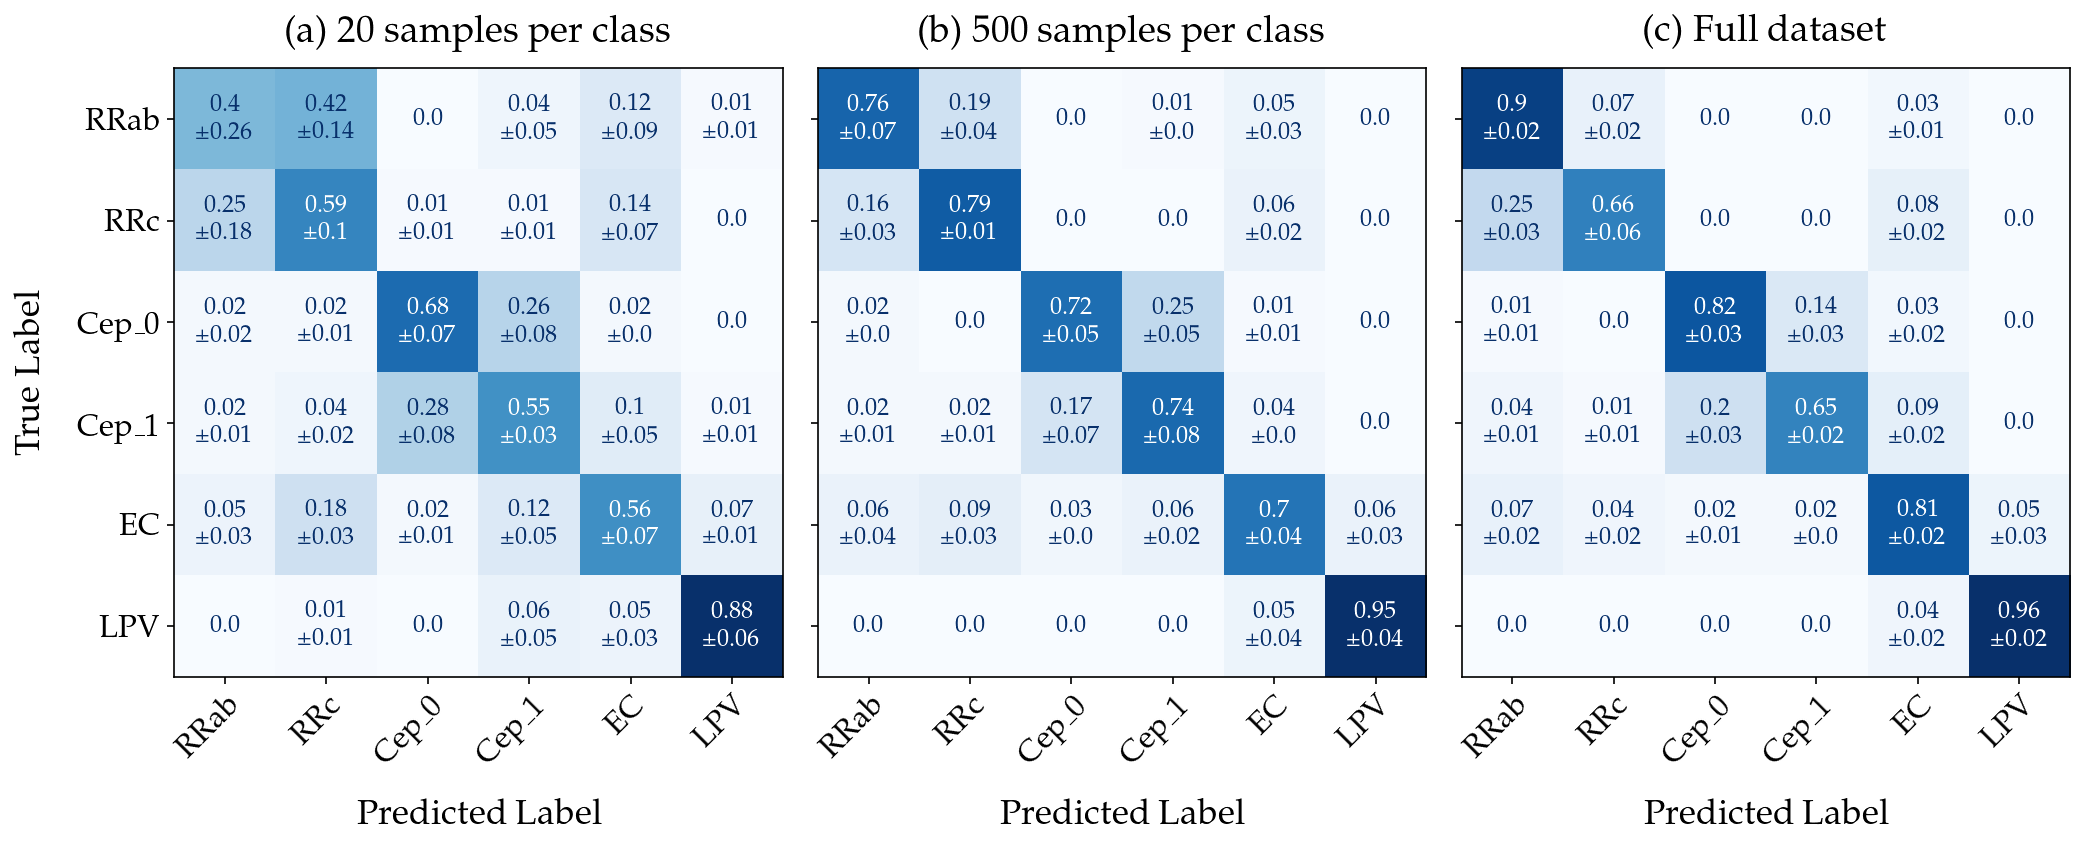

In [ ]:
# Graficando la matriz media
cmap = plt.cm.Blues
#fig, ax = plt.subplots(figsize=(13, 13)) #, dpi=110)
fig, axes = plt.subplots(1, 3, figsize=(14, 14), sharey=True, dpi=150)

titles = ['(a) 20 samples per class', '(b) 500 samples per class', '(c) Full dataset']
mean_matrices_col = [mean_matrix_single_20, mean_matrix_single_500, mean_matrix_single_all]
std_matrices_col = [std_matrix_single_20, std_matrix_single_500, std_matrix_single_all]

for cont, (ax, mean_matrix, std_matrix) in enumerate(zip(axes, mean_matrices_col, std_matrices_col)):
    im = ax.imshow(np.around(mean_matrix, decimals=2), interpolation='nearest', cmap=cmap)

    # color map
    new_color = cmap(1.0) 

    # Añadiendo manualmente las anotaciones con la media y desviación estándar
    for i in range(mean_matrix.shape[0]):
        for j in range(mean_matrix.shape[1]):
            if mean_matrix[i, j] >= 0.005:
                #print(mean_matrix[i, j])
                text = f'{np.around(mean_matrix[i, j], decimals=2)}\n±{np.around(std_matrix[i, j], decimals=2)}'
                color = "white" if mean_matrix[i, j] > 0.5 else new_color  # Blanco para la diagonal, tono de azul para otras celdas
                ax.text(j, i, text, ha="center", va="center", color=color, fontsize=11.7)
            else:
                text = f'{np.around(mean_matrix[i, j], decimals=2)}'
                color = "white" if mean_matrix[i, j] > 0.5 else new_color  # Blanco para la diagonal, tono de azul para otras celdas
                ax.text(j, i, text, ha="center", va="center", color=color, fontsize=11.7)

    # Ajustes finales y mostrar la gráfica
    ax.tick_params(axis='both', which='major', labelsize=15)
    ax.set_xticks(np.arange(len(order_classes)))
    ax.set_yticks(np.arange(len(order_classes)))
    ax.set_xticklabels(order_classes)
    ax.set_yticklabels(order_classes)
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

    ax.xaxis.label.set_size(17)
    ax.yaxis.label.set_size(17)
    ax.xaxis.labelpad = 13
    ax.yaxis.labelpad = 13

    ax.set_title(titles[cont], fontsize=18, pad=13)
    ax.set_xlabel('Predicted Label', fontsize=17)

    if cont == 0:
        ax.set_ylabel('True Label', fontsize=17)

plt.tight_layout()
#os.makedirs('images', exist_ok=True)
#plt.savefig("cm_singleband.pdf", format="pdf", bbox_inches="tight")
plt.show()

## Multi-band MACHO

### 20 samples per class

In [9]:
# 20 SPC - overlay

dict_fold_mlflow = {
    0: '2025-01-26_10-20-39',
    1: '2025-01-26_10-20-39',
    2: '2025-01-26_10-20-39',
}

matrices = []
for fold, run_name in dict_fold_mlflow.items(): 

    config = {
        'mlflow_dir': 'ml-runs',

        'checkpoint': {
            'exp_name': 'ft_classification/macho_multiband/best_params',
            'run_name': run_name,
            'results_dir': './results/macho',
        },

        'loader': {
            'fold': fold
            }
    }

    fold = config['loader']['fold']
    ckpt_dir = handle_ckpt_dir(config, fold=fold)
    ckpt_model = sorted(glob.glob(ckpt_dir + "/*.ckpt"))[-1]

    # Folder
    experiment_id = get_experiment_id_mlflow(config['checkpoint']['exp_name'])
    run_name = f"Fold_{fold}_{config['checkpoint']['run_name']}"
    run_id = get_run_id_mlflow(experiment_id, run_name)
    EXPDIR = '{}/ml-runs/{}/{}/artifacts'.format(config['checkpoint']['results_dir'], experiment_id, run_id)

    df_predictions = pd.read_parquet(f'{EXPDIR}/predictions_test.parquet')
    y_test = df_predictions['y_true'].values
    y_pred = df_predictions['y_pred'].values
    cm = confusion_matrix(y_test, y_pred, labels=order_classes, normalize='true')
    matrices.append(cm)

# Calculando la media y la desviación estándar
mean_matrix_multi_20 = np.mean(matrices, axis=0)
std_matrix_multi_20 = np.std(matrices, axis=0)

### 500 samples per class

In [10]:
# 500 SPC - 2grid

dict_fold_mlflow = {
    0: '2025-01-25_18-34-17',
    1: '2025-01-25_18-34-17',
    2: '2025-01-25_18-34-17',
}

matrices = []
for fold, run_name in dict_fold_mlflow.items(): 

    config = {
        'mlflow_dir': 'ml-runs',

        'checkpoint': {
            'exp_name': 'ft_classification/macho_multiband/best_params',
            'run_name': run_name,
            'results_dir': './results/macho',
        },

        'loader': {
            'fold': fold
            }
    }

    fold = config['loader']['fold']
    ckpt_dir = handle_ckpt_dir(config, fold=fold)
    ckpt_model = sorted(glob.glob(ckpt_dir + "/*.ckpt"))[-1]

    # Folder
    experiment_id = get_experiment_id_mlflow(config['checkpoint']['exp_name'])
    run_name = f"Fold_{fold}_{config['checkpoint']['run_name']}"
    run_id = get_run_id_mlflow(experiment_id, run_name)
    EXPDIR = '{}/ml-runs/{}/{}/artifacts'.format(config['checkpoint']['results_dir'], experiment_id, run_id)

    df_predictions = pd.read_parquet(f'{EXPDIR}/predictions_test.parquet')
    y_test = df_predictions['y_true'].values
    y_pred = df_predictions['y_pred'].values
    cm = confusion_matrix(y_test, y_pred, labels=order_classes, normalize='true')
    matrices.append(cm)

# Calculando la media y la desviación estándar
mean_matrix_multi_500 = np.mean(matrices, axis=0)
std_matrix_multi_500 = np.std(matrices, axis=0)

### Full dataset

In [11]:
# all SPC - 2grid

dict_fold_mlflow = {
    0: '2025-01-25_18-32-34',
    1: '2025-01-25_18-32-34',
    2: '2025-01-25_18-32-34',
}

matrices = []
for fold, run_name in dict_fold_mlflow.items(): 

    config = {
        'mlflow_dir': 'ml-runs',

        'checkpoint': {
            'exp_name': 'ft_classification/macho_multiband/best_params',
            'run_name': run_name,
            'results_dir': './results/macho',
        },

        'loader': {
            'fold': fold
            }
    }

    fold = config['loader']['fold']
    ckpt_dir = handle_ckpt_dir(config, fold=fold)
    ckpt_model = sorted(glob.glob(ckpt_dir + "/*.ckpt"))[-1]

    # Folder
    experiment_id = get_experiment_id_mlflow(config['checkpoint']['exp_name'])
    run_name = f"Fold_{fold}_{config['checkpoint']['run_name']}"
    run_id = get_run_id_mlflow(experiment_id, run_name)
    EXPDIR = '{}/ml-runs/{}/{}/artifacts'.format(config['checkpoint']['results_dir'], experiment_id, run_id)

    df_predictions = pd.read_parquet(f'{EXPDIR}/predictions_test.parquet')
    y_test = df_predictions['y_true'].values
    y_pred = df_predictions['y_pred'].values
    cm = confusion_matrix(y_test, y_pred, labels=order_classes, normalize='true')
    matrices.append(cm)

# Calculando la media y la desviación estándar
mean_matrix_multi_all = np.mean(matrices, axis=0)
std_matrix_multi_all = np.std(matrices, axis=0)

### Confusion matrices (multi-band)

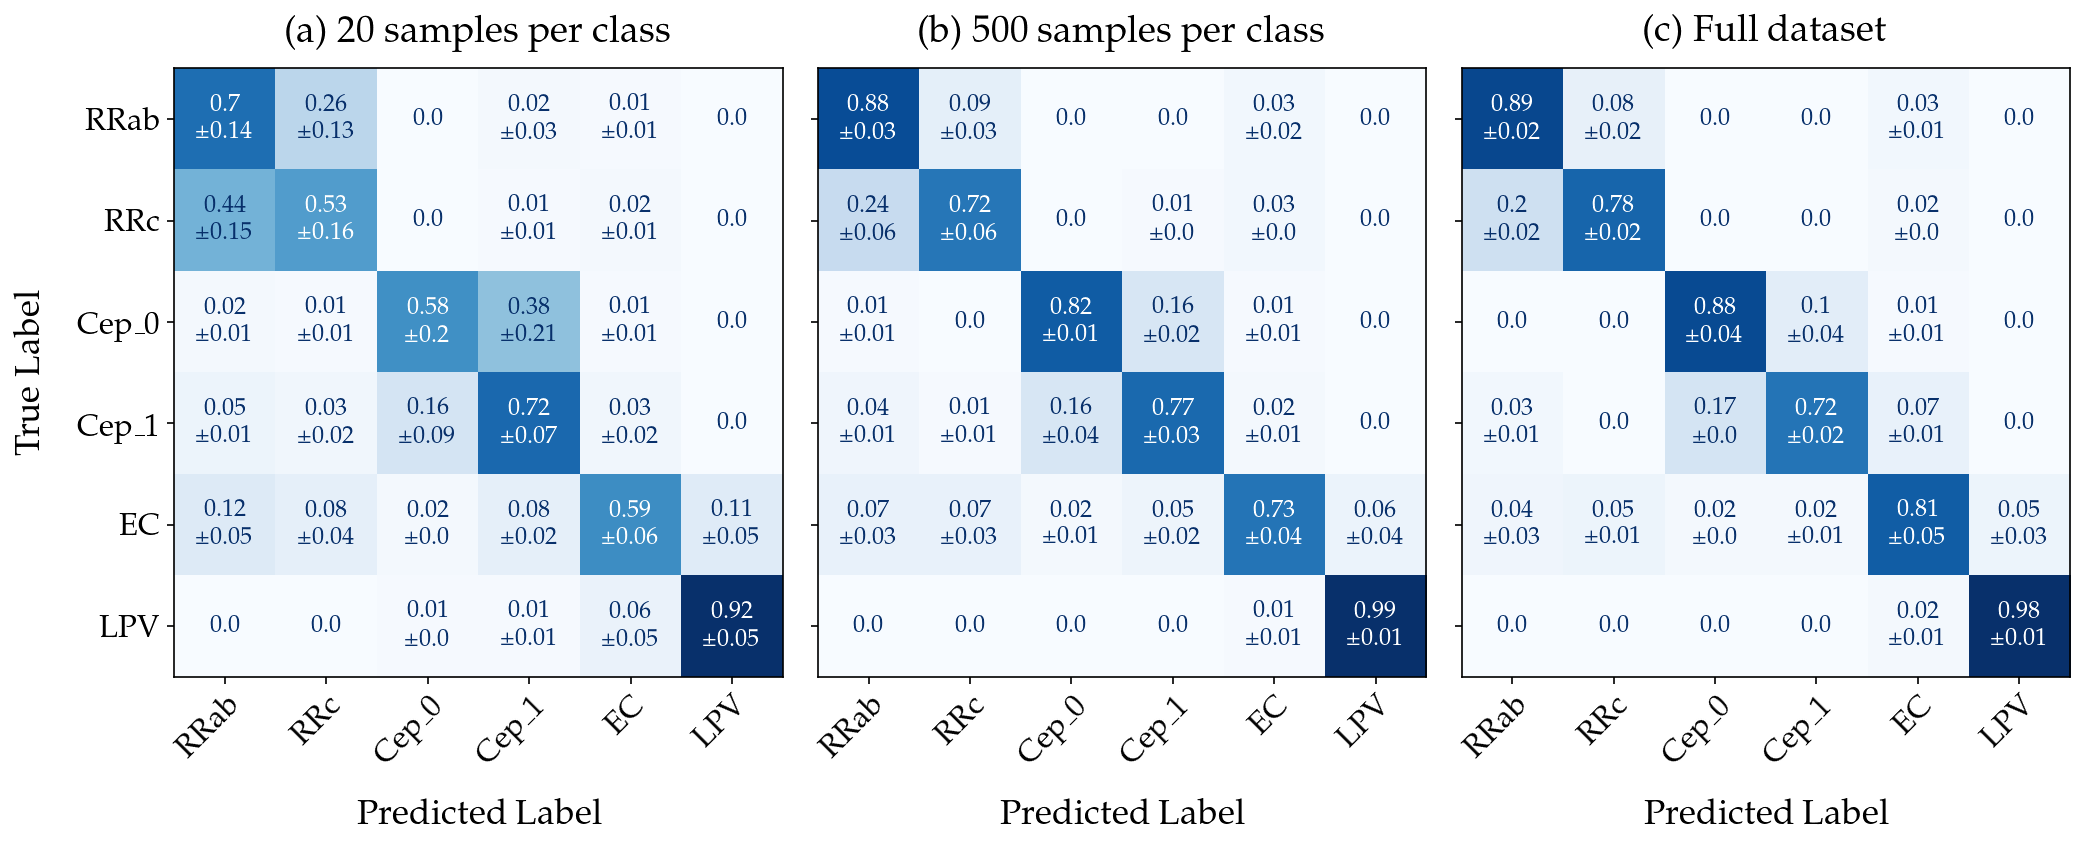

In [ ]:
# Graficando la matriz media
cmap = plt.cm.Blues
#fig, ax = plt.subplots(figsize=(13, 13)) #, dpi=110)
fig, axes = plt.subplots(1, 3, figsize=(14, 14), sharey=True, dpi=150)

titles = ['(a) 20 samples per class', '(b) 500 samples per class', '(c) Full dataset']
mean_matrices_col = [mean_matrix_multi_20, mean_matrix_multi_500, mean_matrix_multi_all]
std_matrices_col = [std_matrix_multi_20, std_matrix_multi_500, std_matrix_multi_all]

for cont, (ax, mean_matrix, std_matrix) in enumerate(zip(axes, mean_matrices_col, std_matrices_col)):
    im = ax.imshow(np.around(mean_matrix, decimals=2), interpolation='nearest', cmap=cmap)

    # color map
    new_color = cmap(1.0) 

    # Añadiendo manualmente las anotaciones con la media y desviación estándar
    for i in range(mean_matrix.shape[0]):
        for j in range(mean_matrix.shape[1]):
            if mean_matrix[i, j] >= 0.005:
                #print(mean_matrix[i, j])
                text = f'{np.around(mean_matrix[i, j], decimals=2)}\n±{np.around(std_matrix[i, j], decimals=2)}'
                color = "white" if mean_matrix[i, j] > 0.5 else new_color  # Blanco para la diagonal, tono de azul para otras celdas
                ax.text(j, i, text, ha="center", va="center", color=color, fontsize=11.7)
            else:
                text = f'{np.around(mean_matrix[i, j], decimals=2)}'
                color = "white" if mean_matrix[i, j] > 0.5 else new_color  # Blanco para la diagonal, tono de azul para otras celdas
                ax.text(j, i, text, ha="center", va="center", color=color, fontsize=11.7)

    # Ajustes finales y mostrar la gráfica
    ax.tick_params(axis='both', which='major', labelsize=15)
    ax.set_xticks(np.arange(len(order_classes)))
    ax.set_yticks(np.arange(len(order_classes)))
    ax.set_xticklabels(order_classes)
    ax.set_yticklabels(order_classes)
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

    ax.xaxis.label.set_size(17)
    ax.yaxis.label.set_size(17)
    ax.xaxis.labelpad = 13
    ax.yaxis.labelpad = 13

    ax.set_title(titles[cont], fontsize=18, pad=13)
    ax.set_xlabel('Predicted Label', fontsize=17)

    if cont == 0:
        ax.set_ylabel('True Label', fontsize=17)

plt.tight_layout()
#os.makedirs('images', exist_ok=True)
#plt.savefig("cm_multiband.pdf", format="pdf", bbox_inches="tight")
plt.show()

## Joint plot of the confusion matrices

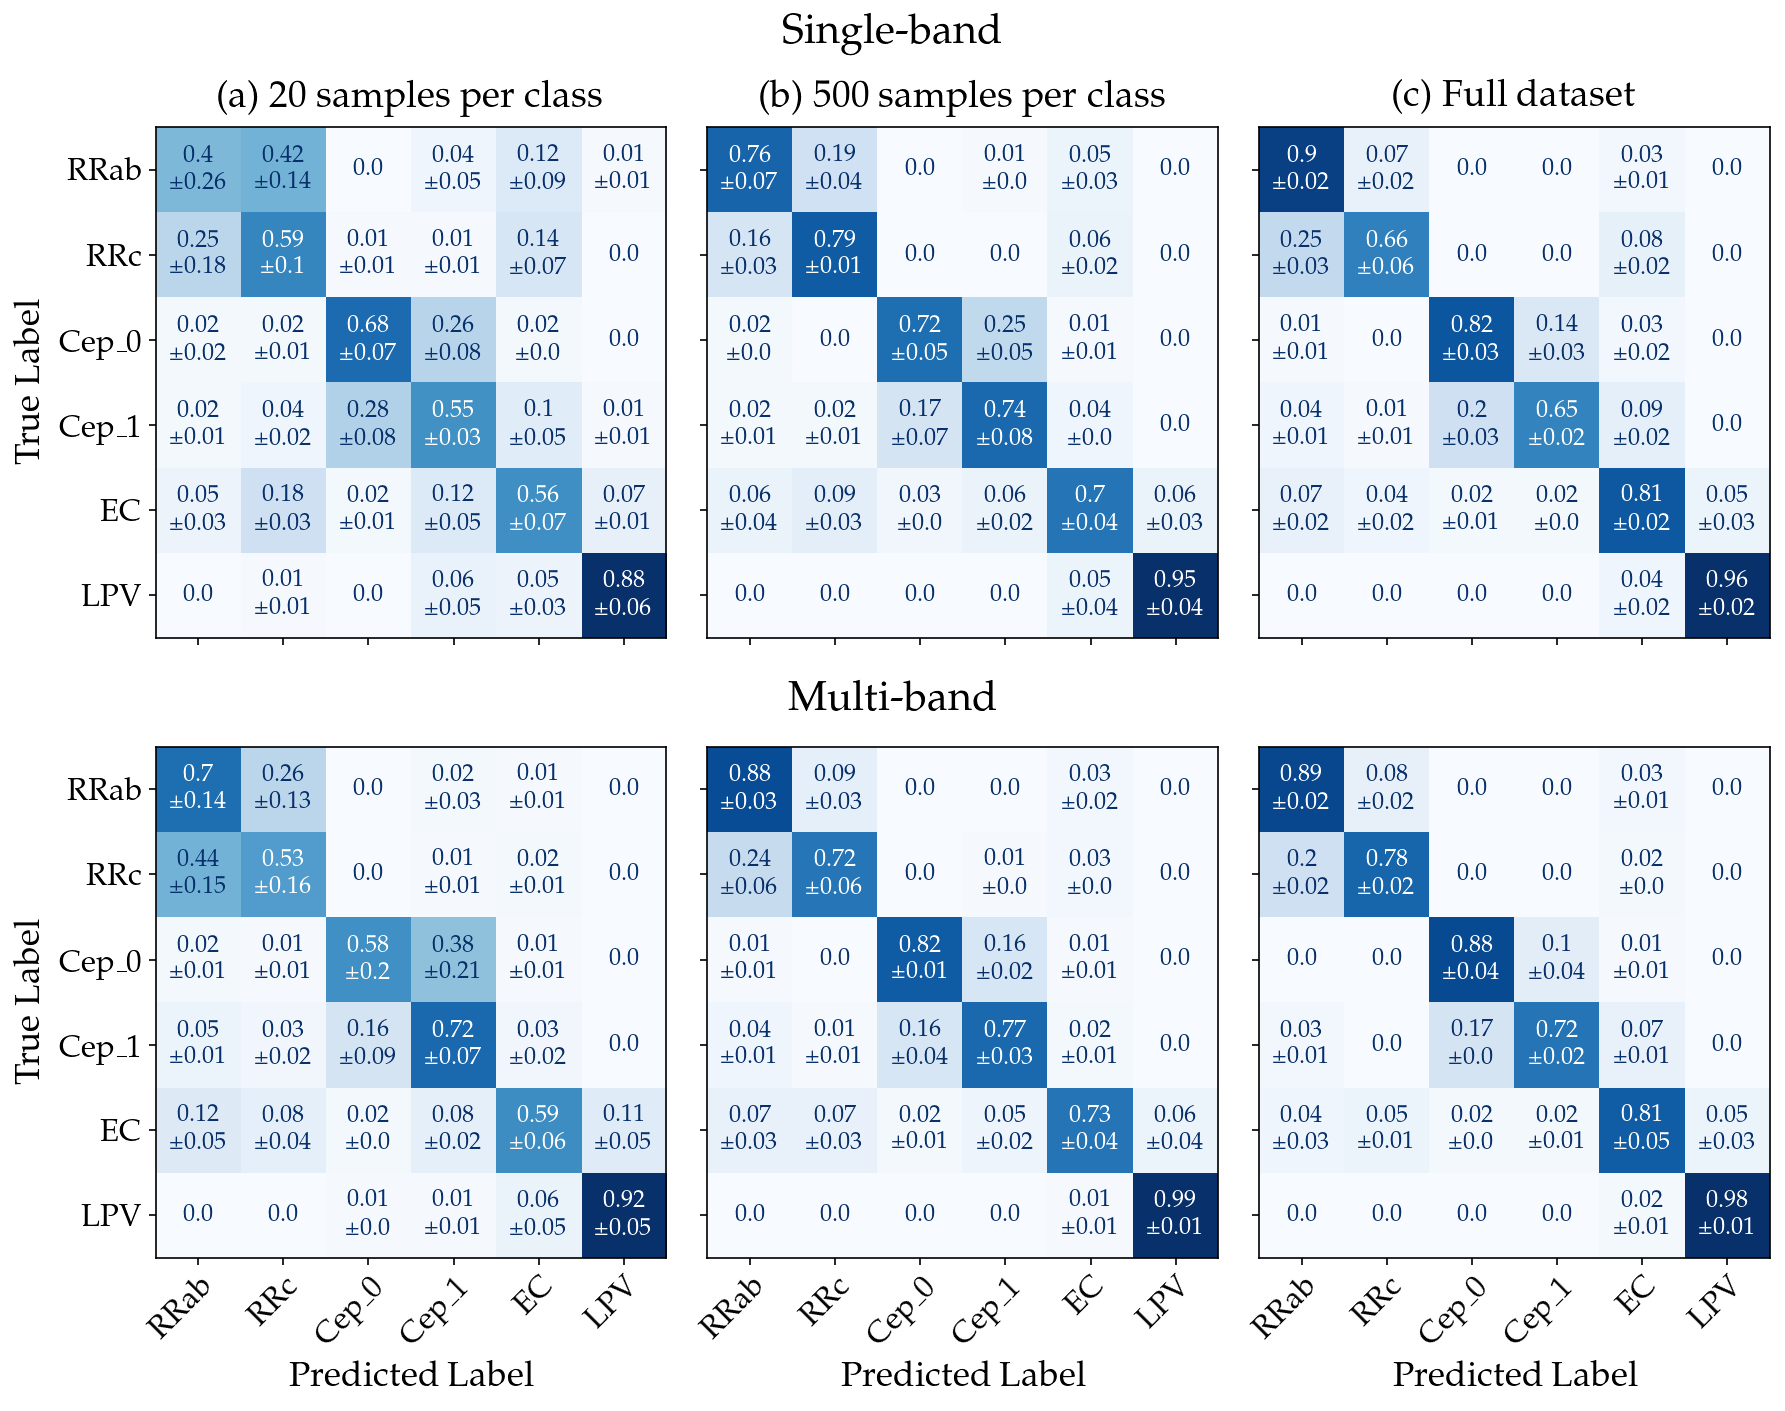

In [13]:
import matplotlib.pyplot as plt
import numpy as np

# Definiendo el colormap
cmap = plt.cm.Blues

# Creando la figura con 2 filas y 3 columnas
fig, axes = plt.subplots(2, 3, figsize=(12, 12), sharex=True, sharey=True, dpi=150)

# Definiendo títulos y matrices para ambas filas
titles = ['(a) 20 samples per class', '(b) 500 samples per class', '(c) Full dataset']
mean_matrices_single = [mean_matrix_single_20, mean_matrix_single_500, mean_matrix_single_all]
std_matrices_single = [std_matrix_single_20, std_matrix_single_500, std_matrix_single_all]
mean_matrices_multi = [mean_matrix_multi_20, mean_matrix_multi_500, mean_matrix_multi_all]
std_matrices_multi = [std_matrix_multi_20, std_matrix_multi_500, std_matrix_multi_all]

# Ajustar espacio entre subgráficos
fig.subplots_adjust(hspace=-0.55)  # Reduce el espacio entre filas

# Agregar etiquetas "Single-band" y "Multi-band" en una mejor posición
fig.text(0.5, 0.865, "Single-band", ha='center', va='center', fontsize=20, fontweight='bold')
fig.text(0.5, 0.495, "Multi-band", ha='center', va='center', fontsize=20, fontweight='bold')

# Iteramos sobre las 2 filas y 3 columnas
for row in range(2):
    for col in range(3):
        ax = axes[row, col]

        # Seleccionar la matriz correspondiente (fila 0: single, fila 1: multi)
        if row == 0:
            mean_matrix = mean_matrices_single[col]
            std_matrix = std_matrices_single[col]
        else:
            mean_matrix = mean_matrices_multi[col]
            std_matrix = std_matrices_multi[col]

        # Graficar la matriz
        im = ax.imshow(np.around(mean_matrix, decimals=2), interpolation='nearest', cmap=cmap)

        # Color para el texto
        new_color = cmap(1.0)

        # Añadiendo anotaciones (media y desviación estándar)
        for i in range(mean_matrix.shape[0]):
            for j in range(mean_matrix.shape[1]):
                if mean_matrix[i, j] >= 0.005:
                    text = f'{np.around(mean_matrix[i, j], decimals=2)}\n±{np.around(std_matrix[i, j], decimals=2)}'
                else:
                    text = f'{np.around(mean_matrix[i, j], decimals=2)}'

                color = "white" if mean_matrix[i, j] > 0.5 else new_color
                ax.text(j, i, text, ha="center", va="center", color=color, fontsize=11.7)

        # Ajustes de ejes y etiquetas
        ax.tick_params(axis='both', which='major', labelsize=15)
        ax.set_xticks(np.arange(len(order_classes)))
        ax.set_yticks(np.arange(len(order_classes)))
        ax.set_xticklabels(order_classes)
        ax.set_yticklabels(order_classes)
        plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

        # Solo mostrar títulos en la primera fila
        if row == 0:
            ax.set_title(titles[col], fontsize=18, pad=10)
        else:
            ax.set_title("")

        # Ocultar ticks del eje x en la primera fila
        if row == 0:
            ax.set_xticklabels([])

        # Etiqueta solo en la primera columna
        if col == 0:
            ax.set_ylabel('True Label', fontsize=17)

        # Etiquetas de ejes solo en la segunda fila
        if row == 1:
            ax.set_xlabel('Predicted Label', fontsize=17)

plt.tight_layout()
os.makedirs(path_save_results, exist_ok=True)
plt.savefig(f"{path_save_results}/cm_macho_combined.pdf", format="pdf", bbox_inches="tight")
plt.show()


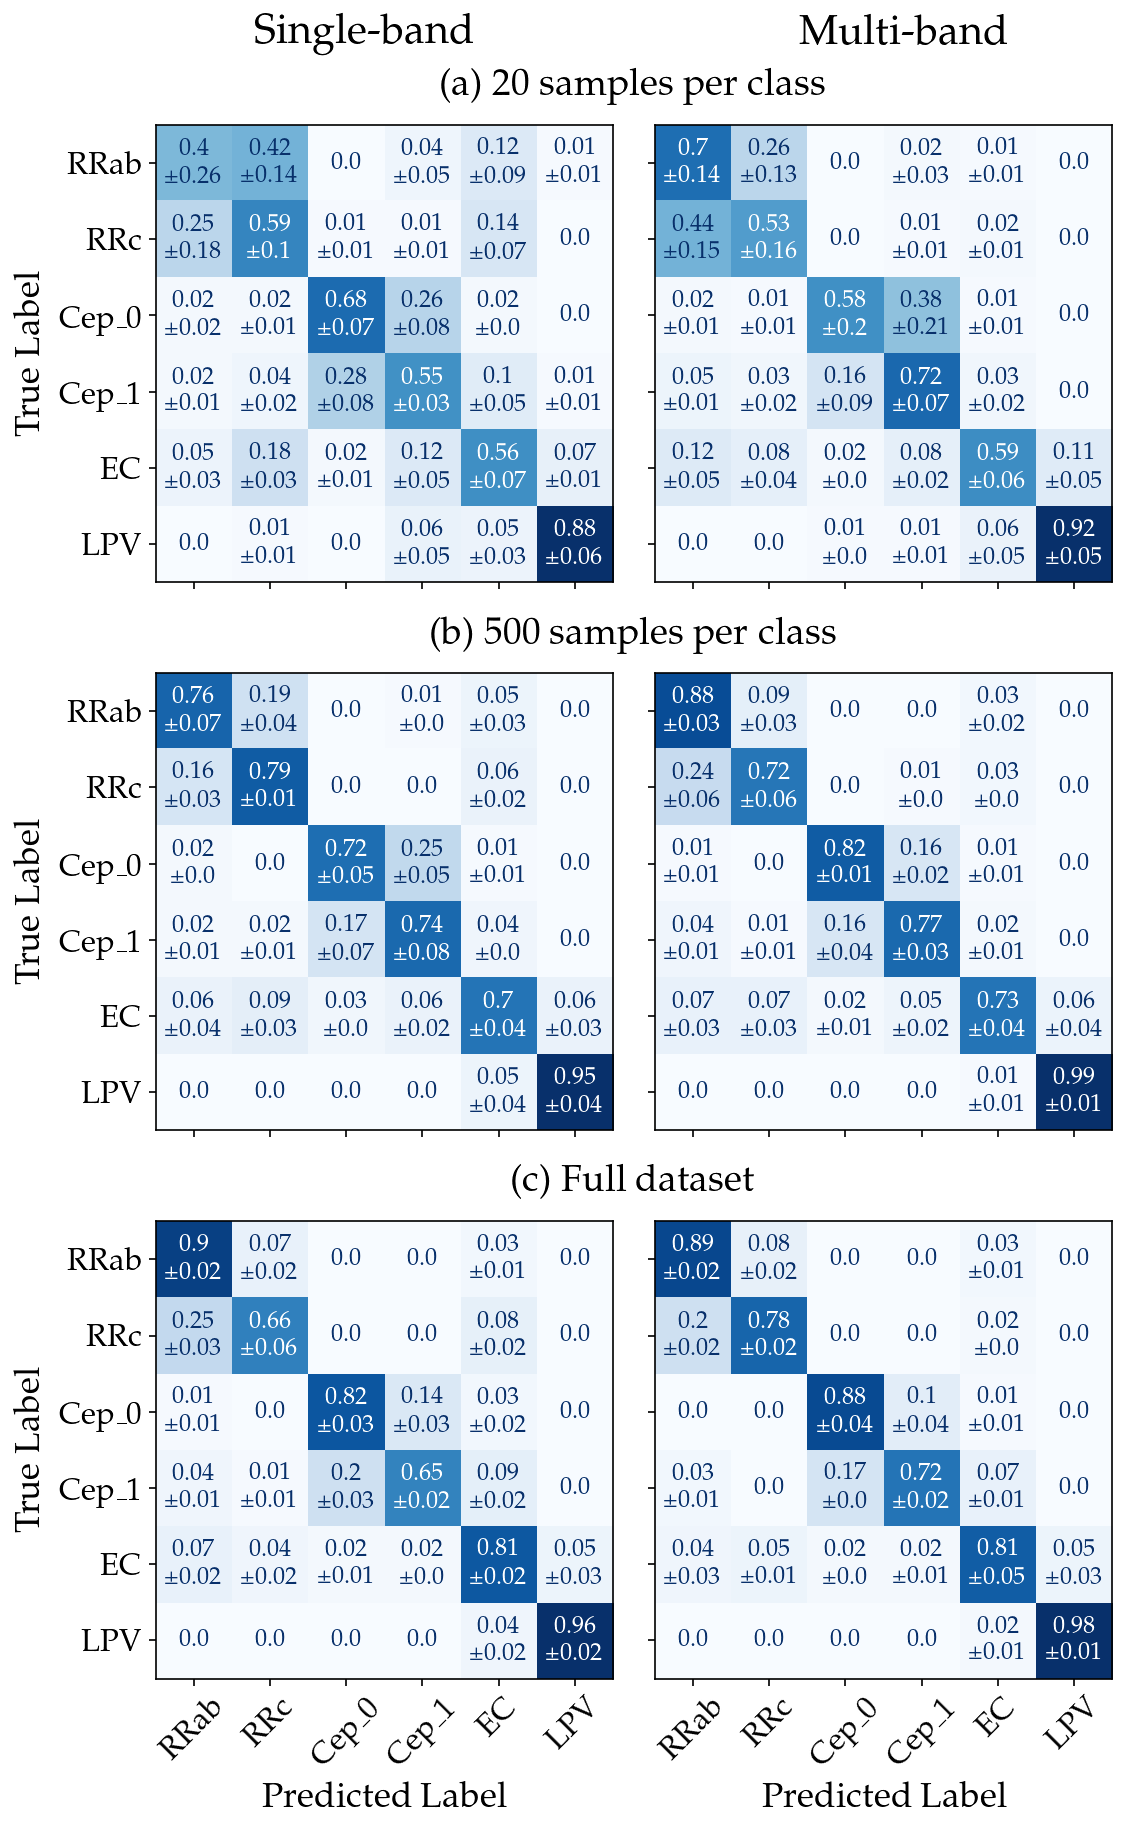

In [75]:
import matplotlib.pyplot as plt
import numpy as np
import os

# Definiendo el colormap
cmap = plt.cm.Blues

# Creando la figura con 3 filas y 2 columnas
fig, axes = plt.subplots(3, 2, figsize=(12, 12), sharex=True, sharey=True, dpi=150)

# Definiendo títulos y matrices para cada fila
titles = ['(a) 20 samples per class', '(b) 500 samples per class', '(c) Full dataset']
mean_matrices_single = [mean_matrix_single_20, mean_matrix_single_500, mean_matrix_single_all]
std_matrices_single = [std_matrix_single_20, std_matrix_single_500, std_matrix_single_all]
mean_matrices_multi = [mean_matrix_multi_20, mean_matrix_multi_500, mean_matrix_multi_all]
std_matrices_multi = [std_matrix_multi_20, std_matrix_multi_500, std_matrix_multi_all]

# Ajustar espacio entre subgráficos
fig.subplots_adjust(hspace=40, wspace=-0.35)

# Agregar etiquetas "Single-band" y "Multi-band" en una mejor posición
fig.text(0.35, 1.013, "Single-band", ha='center', va='center', fontsize=20, fontweight='bold')
fig.text(0.65, 1.013, "Multi-band", ha='center', va='center', fontsize=20, fontweight='bold')

# Agregar etiquetas centradas para cada fila
#for i, title in enumerate(titles):

fig.text(0.5, 0.985, titles[0], ha='center', va='center', fontsize=18, fontweight='bold')
fig.text(0.5, 1.0 - 1 * 0.32, titles[1], ha='center', va='center', fontsize=18, fontweight='bold')
fig.text(0.5, 1.015 - 2 * 0.32, titles[2], ha='center', va='center', fontsize=18, fontweight='bold')

# Iteramos sobre las 3 filas y 2 columnas
for row in range(3):
    for col in range(2):
        ax = axes[row, col]

        # Seleccionar la matriz correspondiente (columna 0: single, columna 1: multi)
        if col == 0:
            mean_matrix = mean_matrices_single[row]
            std_matrix = std_matrices_single[row]
        else:
            mean_matrix = mean_matrices_multi[row]
            std_matrix = std_matrices_multi[row]

        # Graficar la matriz
        im = ax.imshow(np.around(mean_matrix, decimals=2), interpolation='nearest', cmap=cmap)

        # Color para el texto
        new_color = cmap(1.0)

        # Añadiendo anotaciones (media y desviación estándar)
        for i in range(mean_matrix.shape[0]):
            for j in range(mean_matrix.shape[1]):
                if mean_matrix[i, j] >= 0.005:
                    text = f'{np.around(mean_matrix[i, j], decimals=2)}\n±{np.around(std_matrix[i, j], decimals=2)}'
                else:
                    text = f'{np.around(mean_matrix[i, j], decimals=2)}'
                
                color = "white" if mean_matrix[i, j] > 0.5 else new_color
                ax.text(j, i, text, ha="center", va="center", color=color, fontsize=11.7)

        # Ajustes de ejes y etiquetas
        ax.tick_params(axis='both', which='major', labelsize=15)
        ax.set_xticks(np.arange(len(order_classes)))
        ax.set_yticks(np.arange(len(order_classes)))
        ax.set_xticklabels(order_classes)
        ax.set_yticklabels(order_classes)
        #plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
        plt.setp(ax.get_xticklabels(), rotation=45, ha='center', va='top', rotation_mode="default")

        # Solo mostrar títulos en la primera columna
        if col == 0:
            ax.set_title('', fontsize=18, pad=10)

        # Etiqueta solo en la primera columna
        if col == 0:
            ax.set_ylabel('True Label', fontsize=17)

        # Etiquetas de ejes solo en la última fila
        if row == 2:
            ax.set_xlabel('Predicted Label', fontsize=17)

plt.tight_layout(pad=2)
os.makedirs(path_save_results, exist_ok=True)
plt.savefig(f"{path_save_results}/cm_macho_combined_vertical.pdf", format="pdf", bbox_inches="tight")
plt.show()
